In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import pandas as pd
import numpy as np

from src import paths
from src.visualization.plots import plot_ndvi_signal
from src.features.slice_time_series import create_multivariate_training_data, create_training_data
from src.models.forecasting import Forecaster

from reservoirpy.nodes import Reservoir, RLS
import pickle
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score
)

# Importación directa de píxeles denoised

In [3]:
denoised_esn_signal_df = pd.read_csv(paths.data_processed_dir(
    "esn", "denoised_esn_signal.csv"), index_col=["ID", "IDpix"])
denoised_esn_signal_df.columns = pd.to_datetime(denoised_esn_signal_df.columns)

esn_metadata_df = pd.read_csv(paths.data_processed_dir(
    "esn", "denoised_esn_metadata.csv"), index_col=["ID", "IDpix"])

In [4]:
denoised_esn_signal_df

2000-10-08  2000-10-15  2000-10-22  2000-10-29  2000-11-05  \
ID  IDpix                                                               
278 3955     0.790838    0.788287    0.775122    0.762697    0.738868   
    3956     0.791300    0.800170    0.792141    0.776144    0.751272   
    3957     0.753050    0.765975    0.763364    0.745024    0.723415   
    3958     0.723525    0.735659    0.726444    0.702203    0.683448   
    3959     0.732804    0.751616    0.754264    0.733620    0.708662   
...               ...         ...         ...         ...         ...   
297 5024     0.793837    0.794983    0.811777    0.791199    0.778060   
    5025     0.782279    0.777094    0.799669    0.770607    0.750866   
    5026     0.782319    0.777090    0.799732    0.770502    0.750903   
    5027     0.802424    0.795242    0.813685    0.778279    0.766847   
    5028     0.814511    0.807902    0.826665    0.794320    0.776007   

           2000-11-12  2000-11-19  2000-11-26  2000-12-03  2000-12-10  ...  \
ID  IDpix                                                              ...   
278 3955     0.733325    0.708209    0.709182    0.717707    0.719737  ...   
    3956     0.736716    0.708288    0.698037    0.701546    0.696291  ...   
    3957     0.714274    0.693976    0.679964    0.696341    0.701594  ...   
    3958     0.673063    0.646094    0.637127    0.647419    0.656692  ...   
    3959     0.700326    0.678598    0.666609    0.675054    0.679120  ...   
...               ...         ...         ...         ...         ...  ...   
297 5024     0.770664    0.750010    0.739540    0.755577    0.737076  ...   
    5025     0.736187    0.706884    0.693601    0.706967    0.696755  ...   
    5026     0.736247    0.706768    0.694373    0.706757    0.696378  ...   
    5027     0.759998    0.735090    0.724264    0.731343    0.717138  ...   
    5028     0.766060    0.743278    0.719858    0.725402    0.699897  ...   

           2022-09-25  2022-10-02  2022-10-09  2022-10-16  2022-10-23  \
ID  IDpix                                                               
278 3955     0.594904    0.487513    0.368717    0.623393    0.612874   
    3956     0.587914    0.471733    0.346678    0.609721    0.583430   
    3957     0.596517    0.485276    0.366383    0.610519    0.579896   
    3958     0.584070    0.472927    0.362513    0.616018    0.584196   
    3959     0.586028    0.494447    0.392062    0.605965    0.603515   
...               ...         ...         ...         ...         ...   
297 5024     0.768154    0.738969    0.716459    0.733431    0.740785   
    5025     0.780156    0.758694    0.745368    0.753581    0.751059   
    5026     0.780224    0.758594    0.745409    0.753650    0.750955   
    5027     0.767172    0.731728    0.709317    0.733372    0.744298   
    5028     0.742878    0.714583    0.698483    0.726648    0.745972   

           2022-10-30  2022-11-06  2022-11-13  2022-11-20  2022-11-27  
ID  IDpix                                                              
278 3955     0.624476    0.608662    0.586352    0.555502    0.553784  
    3956     0.571611    0.564613    0.548850    0.537485    0.522340  
    3957     0.579206    0.566785    0.541887    0.504939    0.503694  
    3958     0.548834    0.537794    0.525908    0.502763    0.497285  
    3959     0.550380    0.542814    0.532534    0.514831    0.507322  
...               ...         ...         ...         ...         ...  
297 5024     0.733375    0.738444    0.736162    0.735412    0.707819  
    5025     0.744952    0.765089    0.762698    0.750279    0.730327  
    5026     0.745730    0.779196    0.772856    0.752673    0.730890  
    5027     0.738640    0.769367    0.759879    0.735868    0.716973  
    5028     0.735575    0.724282    0.724624    0.722387    0.704190  

[3185 rows x 1156 columns]

In [5]:
esn_metadata_df

lat        lon change_type change_start vegetation_type
ID  IDpix                                                               
278 3955  -33.667554 -70.522556     drought   17/03/2004          native
    3956  -33.667285 -70.521747     drought   17/03/2004          native
    3957  -33.666746 -70.521747     drought   17/03/2004          native
    3958  -33.667554 -70.522017     drought   17/03/2004          native
    3959  -33.667015 -70.522286     drought   17/03/2004          native
...              ...        ...         ...          ...             ...
297 5024  -33.957530 -71.129727     drought   12/02/2006          native
    5025  -33.956991 -71.127571     drought   12/02/2006          native
    5026  -33.956183 -71.129188     drought   12/02/2006          native
    5027  -33.959417 -71.132961     drought   12/02/2006          native
    5028  -33.958339 -71.133500     drought   12/02/2006          native

[3185 rows x 5 columns]

## Evaluar calidad del denoising de pixeles

In [ ]:
# TODO

# Conjuntos de entrenamiento y validación

## Ejemplo

In [6]:
# Ejemplo sobre funcionamiento de partición train-test

ts_data = np.array([
    [i for i in range(10)],
    [i * 10 for i in range(10)],
])

num_features = 3
train_size = 4
Xtrain, ytrain, Xtest, ytest = create_multivariate_training_data(
    ts_data, num_features, train_size)

In [7]:
ts_data

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]])

In [8]:
Xtrain, ytrain.reshape(-1, 1)

(array([[ 0,  1,  2],
        [ 1,  2,  3],
        [ 2,  3,  4],
        [ 3,  4,  5],
        [ 0, 10, 20],
        [10, 20, 30],
        [20, 30, 40],
        [30, 40, 50]]),
 array([[ 3],
        [ 4],
        [ 5],
        [ 6],
        [30],
        [40],
        [50],
        [60]]))

In [9]:
Xtest, ytest.reshape(-1, 1)

(array([[ 4,  5,  6],
        [ 5,  6,  7],
        [ 6,  7,  8],
        [40, 50, 60],
        [50, 60, 70],
        [60, 70, 80]]),
 array([[ 7],
        [ 8],
        [ 9],
        [70],
        [80],
        [90]]))

## Partición train-test

In [6]:
dates = denoised_esn_signal_df.iloc[0].index
denoised_ts = denoised_esn_signal_df.to_numpy()

In [7]:
dates

DatetimeIndex(['2000-10-08', '2000-10-15', '2000-10-22', '2000-10-29',
               '2000-11-05', '2000-11-12', '2000-11-19', '2000-11-26',
               '2000-12-03', '2000-12-10',
               ...
               '2022-09-25', '2022-10-02', '2022-10-09', '2022-10-16',
               '2022-10-23', '2022-10-30', '2022-11-06', '2022-11-13',
               '2022-11-20', '2022-11-27'],
              dtype='datetime64[ns]', length=1156, freq=None)

In [33]:
num_features = 104
training_years = 10
train_size = 52 * training_years
# num_pix, T = denoised_ts.shape

In [34]:
# num_pix * (520 - 104)

In [35]:
dates[train_size + num_features - 1]  # Training limit date

NameError: name 'dates' is not defined

In [15]:
Xtrain, ytrain, Xval, yval = create_multivariate_training_data(
    denoised_ts, num_features=num_features, train_size=train_size)

In [ ]:
assert Xtrain.shape[0] == ytrain.shape[0]

In [ ]:
assert Xval.shape[0] == yval.shape[0]

In [ ]:
# Adjust target vectors format
ytrain = ytrain.reshape(-1, 1)
yval = yval.reshape(-1, 1)

In [ ]:
Xtrain.shape

In [ ]:
Xval.shape

# Definición y entrenamiento ESN

El entrenamiento de la red fue llevado a cabo en un colab notebook, pues el tamaño del arreglo numpy resultante es muy grande para ser cargado a la memoria de un laptop.

## ESN básica


In [ ]:
# Layers
reservoir = Reservoir(500, lr=0.5, sr=0.9)
readout = RLS()

# Echo state network
esn_model = reservoir >> readout

In [ ]:
# Fit model
predictions = esn_model.train(Xtrain, ytrain)

In [ ]:
# Predict
ypred = esn_model.run(Xval)

In [ ]:
print("ESN:")
print("MAPE:", mean_absolute_percentage_error(yval, ypred))
print("MAE:", mean_absolute_error(yval, ypred))
print("MSE:", mean_squared_error(yval, ypred))
print("R2:", r2_score(yval, ypred))

In [ ]:
# Save trained ESN

model_path = paths.models_dir("trained-esn-pix-non-feedback.pickle")

with open(model_path, 'wb') as file:
    pickle.dump(esn_model, file)

## ESN feedback

In [ ]:
# ESN definition

# Layers
reservoir = Reservoir(500, lr=0.5, sr=0.9)
readout = RLS()

# Feedback connection
reservoir <<= readout

# Echo state network
feedback_model = reservoir >> readout

In [ ]:
# Fit model
predictions = feedback_model.train(Xtrain, ytrain)

In [ ]:
# Predict
ypred = feedback_model.run(Xval)

In [ ]:
print("ESN con feedback:")
print("MAPE:", mean_absolute_percentage_error(yval, ypred))
print("MAE:", mean_absolute_error(yval, ypred))
print("MSE:", mean_squared_error(yval, ypred))
print("R2:", r2_score(yval, ypred))

In [ ]:
# Save trained ESN-fb

model_path = paths.models_dir("trained-esn-pix-feedback.pickle")

with open(model_path, 'wb') as file:
    pickle.dump(feedback_model, file)

# Importación directa de modelo entrenado

In [11]:
# Import trained esn
model_path = paths.models_dir("trained-esn-pix-non-feedback.pickle")

with open(model_path, 'rb') as file:
    trained_esn = pickle.load(file)

# Visualización de predicciones

In [18]:
denoised_esn_signal_df.index[45]

(296, 4706)

In [40]:
pix_index = denoised_esn_signal_df.index[45]
example_pixel = denoised_esn_signal_df.loc[pix_index]
dates = example_pixel.index

print("pix id: ", example_pixel.name)

pix id:  (296, 4706)


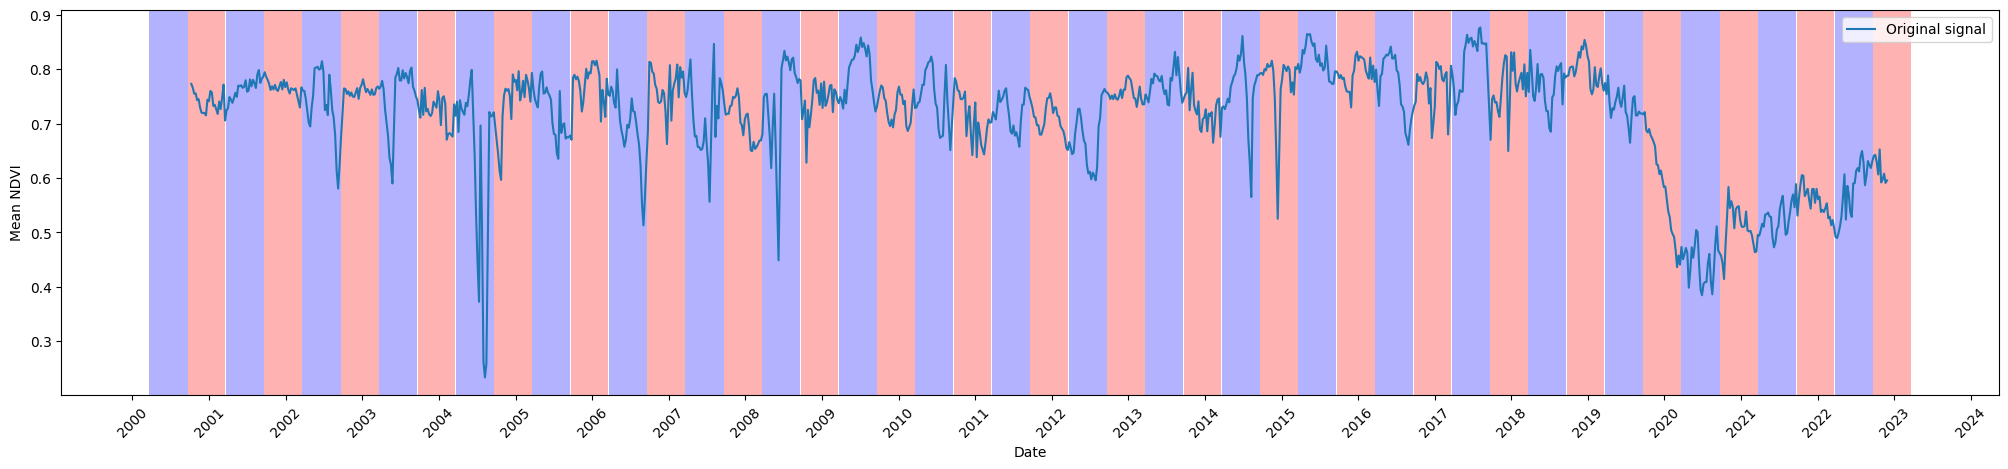

In [29]:
# Example polygon visualization
plot_ndvi_signal(example_pixel, labels=["Original signal", "Denoised signal"])

In [23]:
curr_model = trained_esn

In [41]:
Xex, yex = create_training_data(
    example_pixel.to_numpy(), num_features=num_features)

Xex_test = Xex[train_size:]
yex_test = yex[train_size:]

pred_dates = dates[train_size + num_features:]

yex_pred = curr_model.run(Xex_test)

Running Model-0: 189it [00:00, 1885.94it/s]           

Running Model-0: 532it [00:00, 1977.03it/s]


In [42]:
# Model metrics

print("MAPE:", mean_absolute_percentage_error(yex_test, yex_pred))
print("MAE:", mean_absolute_error(yex_test, yex_pred))
print("MSE:", mean_squared_error(yex_test, yex_pred))
print("R2:", r2_score(yex_test, yex_pred))

MAPE: 0.039393668914594525
MAE: 0.025256871044600795
MSE: 0.0011596884354815146
R2: 0.9223341814760028


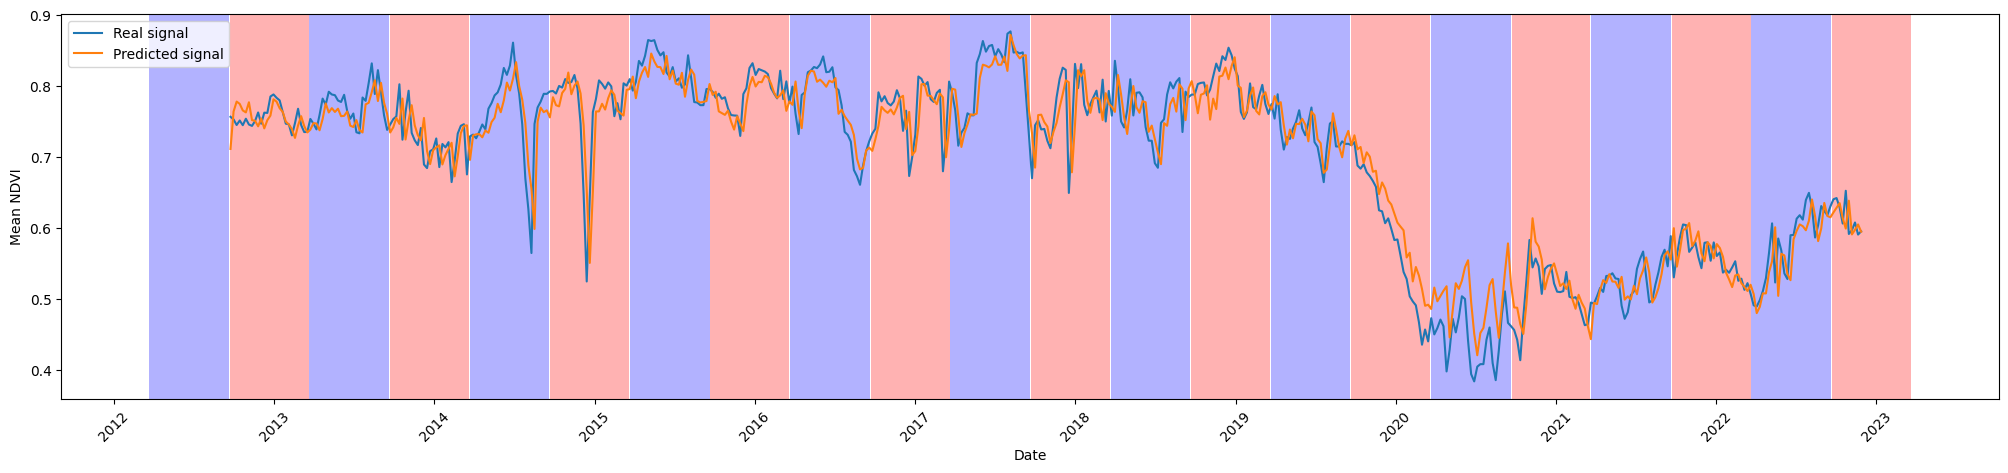

In [43]:
yex_test_series = pd.Series(yex_test.flatten(), index=pred_dates)
yex_pred_series = pd.Series(yex_pred.flatten(), index=pred_dates)

plot_ndvi_signal(yex_test_series, yex_pred_series, labels=[
                 "Real signal", "Predicted signal"], show_dots=False)

# Forecasting con modelo pre-entrenado

In [45]:
Xex, yex = create_training_data(
    example_pixel.to_numpy(), num_features=num_features)

# Adjust target vectors format
yex = yex.reshape(-1, 1)

# Train-test split
forecasting_train_years = 19
forecasting_train_size = (forecasting_train_years * 52)
forecasting_test_size = 52

Xex_train = Xex[:forecasting_train_size]
yex_train = yex[:forecasting_train_size]

Xex_test = Xex[-forecasting_test_size:]
yex_test = yex[-forecasting_test_size:]

pred_dates = dates[-forecasting_test_size:]

In [48]:
forecaster = Forecaster(curr_model, num_features=num_features)
forecaster.train(Xex_train, yex_train)

In [49]:
warmup_X = Xex_train[-2 * num_features:, :]
forecast = forecaster.forecast(T=forecasting_test_size, warmup_X=warmup_X)

Running Model-0: 208it [00:00, 1904.00it/s]           
Running Model-0: 100%|██████████| 1/1 [00:00<00:00, 482.55it/s]


In [50]:
mape = mean_absolute_percentage_error(yex_test, forecast)
mae = mean_absolute_error(yex_test, forecast)
mape, mae

(0.13812938449417206, 0.0806666150669279)

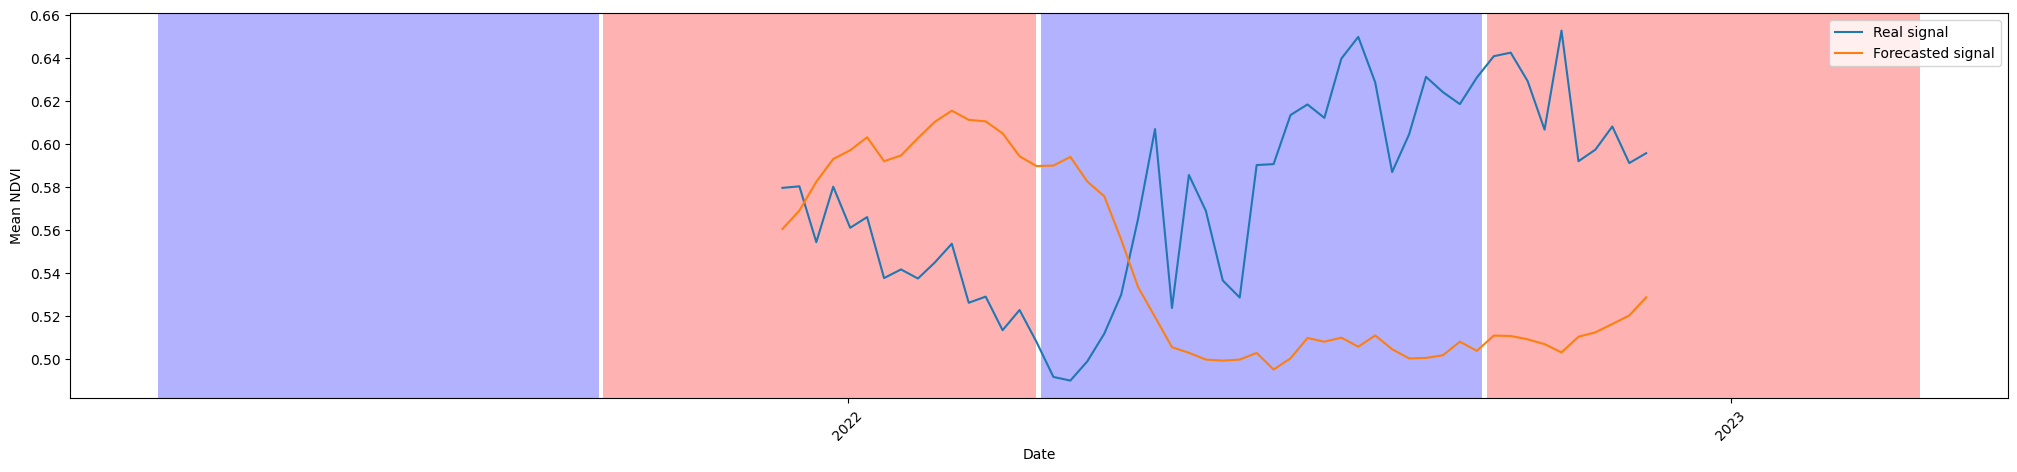

In [51]:
yex_test_series = pd.Series(yex_test.flatten(), index=pred_dates)
forecast_series = pd.Series(forecast.flatten(), index=pred_dates)

plot_ndvi_signal(yex_test_series, forecast_series, labels=[
                 "Real signal", "Forecasted signal"])